# Latitude by Latitude Quantile Plots
This notebook produces plots to illustrate how the high quantiles for near surface air temperature vary with longwave optical depth ($CO_2$ concentration proxy) on an aquaplanet.

It combines all simulations run in each plot.

It is similar to `quantile_notebook2_summer.ipynb` except that it combines variables and theories for each latitude independently before area averaging them in the final plots.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import L_v, c_p
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed

2023-05-09 11:29:03,268 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset
var_keep = ['temp', 'sphum']
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values - get rid of pfull coordinate
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull) * 100

100%|██████████| 8/8 [00:10<00:00,  1.35s/it]


## Near Surface Temperature Quantile
Plot quantile of near surface air temperature vs global average near surface air temperature for a given latitude band.

Near surface air temperature is the temperature at the lowest pressure level.

Here, we compute the quantile at each latitude coordinate across all longitudes and time and then average over these.

We average over all times after 2 years because, from the spin up plot above, after 2 years, the simulation has converged into a regular pattern, with a net TOA flux centered on 0.

In [52]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
# season = 'summer'
season = 'all'

# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
region = 'Global'
lat_min = 0
lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 8/8 [00:09<00:00,  1.24s/it]


In [53]:
quantiles_all = np.arange(1, 100)
median_quant_ind = np.where(quantiles_all==50)[0][0]
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
# two different types of temperature quantiles, p is actual percentile. x is averaged over given percentile.
temp_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant_p = np.zeros((n_exp, n_lat, n_quant_all))
temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
temp_median = np.zeros((n_exp, n_lat))
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean[i] = ds_all[i].sphum.mean(dim='lon_time')
        temp_median[i] = ds_all[i].temp.median(dim='lon_time')
        temp_quant_p[i] = ds_all[i].temp.quantile(quantiles_all/100, dim='lon_time').transpose()
        sphum_quant_p[i] = ds_all[i].sphum.quantile(quantiles_all/100, dim='lon_time').transpose()
        pbar.update(1)

100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


In [54]:
# For given quantiles, plot quantile vs average temp for each latitude.
# Then fit best line to this to get simulated gradient, combining all kappa values
quant_plot = [90, 95, 99]
quant_plot_ind = numpy_indexed.indices(quantiles_all, quant_plot)
n_quant_plot = len(quant_plot)
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

def get_gradient(temp_quant, temp_av, ref_ind):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int

    Returns:
        int
            Gradient
        [n_exp]
            Predicted temperature for each experiment
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[0]
    return param, fit_func(temp_av, param)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
temp_quant_grad = np.zeros((n_lat, n_quant_plot))
temp_quant_grad_fit = np.zeros((n_exp, n_lat, n_quant_plot))
for i in range(n_lat):
    for j in range(n_quant_plot):
        temp_quant_grad[i, j], temp_quant_grad_fit[:, i, j] = get_gradient(temp_quant_p[:, i, quant_plot_ind[j]],
                                                                           temp_mean[:, i], tau_ref_ind)

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

In [55]:
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

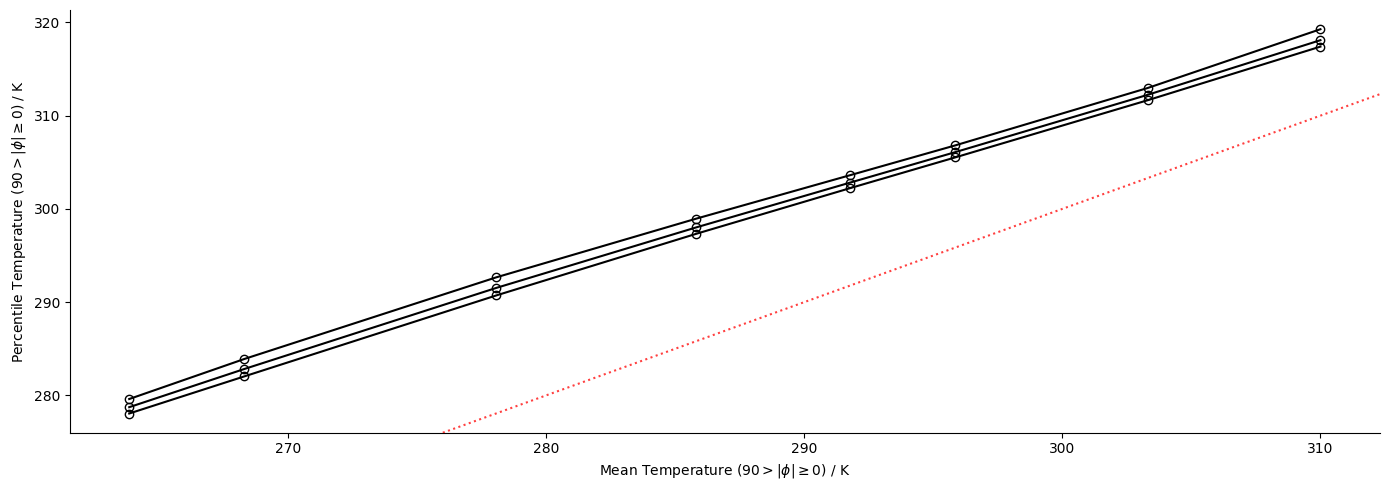

In [56]:
trend_line_on = False
save_trend_fig = False

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]

temp_mean_weight = np.average(temp_mean, axis=1, weights=lat_weights)
temp_quant_weight = np.average(temp_quant_p, axis=1, weights=lat_weights)

fig, ax = plt.subplots(1,1, figsize=(14, 5))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    ax.plot(temp_mean_weight,
            temp_quant_weight[:, quant_plot_ind[j]],
            marker='o',
            label='{}$^{}$ ({:.2f} K/K)'.format(quant_plot[j],'{th}', np.average(temp_quant_grad[:, j], weights=lat_weights)),
            color='k', fillstyle='none')
    if trend_line_on:
        # Filled circle for reference simulation
        ax.plot(temp_mean_weight[tau_ref_ind],
                temp_quant_weight[tau_ref_ind, quant_plot_ind[j]],
                marker='o', color='k', fillstyle='full')
        if j==n_quant_plot-1:
            label = 'Linear Increase'
        else:
            label = None
        ax.plot(temp_mean_weight,
                np.average(temp_quant_grad_fit[:, :, j], axis=1, weights=lat_weights),
                linestyle=':', color='k', alpha=0.3, label=label)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([ax.get_ylim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
if trend_line_on:
    ax.legend(title='Percentile - Gradient', frameon=False)
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax.set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax.set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
plt.tight_layout()
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Theory for predicting next temperature based on the previous $\kappa$
This adds the theory prediction of temperature percentile to the above plot. The theory can predict the temperature at the next kappa value based on the previous optical depth value.

In [57]:
# get theory predictions for all quantiles
delta_temp_quant = np.diff(temp_quant_p, axis=0)
delta_temp_median = np.diff(temp_median, axis=0)

delta_temp_quant_theory = np.zeros((n_exp-1, n_lat, n_quant_all))
delta_temp_quant_theory_const_rh = np.zeros((n_exp-1, n_lat, n_quant_all))
# theory1 adds theoretical delta_temp to simulated value of previous kappa
temp_quant_theory = temp_quant_p.copy()
temp_quant_theory_const_rh = temp_quant_p.copy()
# theory2 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory2 = temp_quant_p.copy()
temp_quant_theory2_const_rh = temp_quant_p.copy()
for i in range(n_lat):
    delta_temp_quant_theory[:, i, :] = get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant_p[:, i],
                                                                   sphum_quant_p[:, i], p_surface)
    delta_temp_quant_theory_const_rh[:, i, :] = get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant_p[:, i],
                                                                            sphum_quant_p[:, i], p_surface, True)
    temp_quant_theory[1:] = temp_quant_p[:-1] + delta_temp_quant_theory
    temp_quant_theory_const_rh[1:] = temp_quant_p[:-1] + delta_temp_quant_theory_const_rh
for j in range(n_exp-1):
    temp_quant_theory2[1+j] = temp_quant_theory2[j] + delta_temp_quant_theory[j]
    temp_quant_theory2_const_rh[1+j] = temp_quant_theory2_const_rh[j] + delta_temp_quant_theory_const_rh[j]


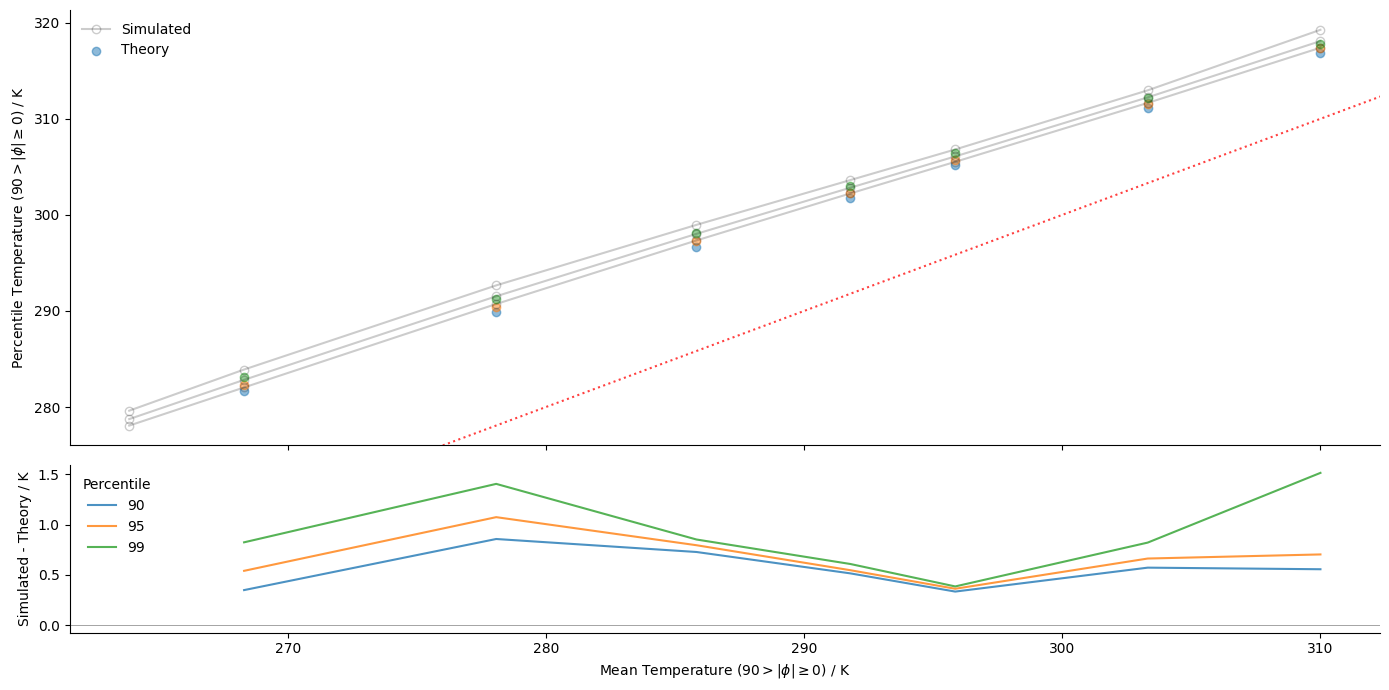

In [58]:
const_rh = False   # which version of theory to plot
save_trend_theory_fig = False
if const_rh:
    theory_use = temp_quant_theory_const_rh
    delta_theory_use = delta_temp_quant_theory_const_rh
else:
    theory_use = temp_quant_theory
    delta_theory_use = delta_temp_quant_theory

fig, ax = plt.subplots(2,1, figsize=(14, 7), sharex=True, gridspec_kw={'height_ratios': [2.6, 1]})
ax[0].spines[['right', 'top']].set_visible(False)
ax[1].spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    ax[0].plot(temp_mean_weight, temp_quant_weight[:, quant_plot_ind[j]],
               marker='o', color='k', fillstyle='none', alpha=0.2)
    ax[0].scatter(temp_mean_weight[1:],
                  np.average(theory_use[:, :, quant_plot_ind[j]], axis=1, weights=lat_weights)[1:], alpha=0.5)
    ax[1].plot(temp_mean_weight[1:],
               temp_quant_weight[1:, quant_plot_ind[j]]-
               np.average(theory_use[:, :, quant_plot_ind[j]], axis=1, weights=lat_weights)[1:], label=quant_plot[j], alpha=0.8)
ax[0].legend(['Simulated', 'Theory'], loc='upper left', frameon=False)
ax[1].legend(title='Percentile', loc='upper left', frameon=False)
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[1].hlines(0, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax[0].plot([ax[0].get_ylim()[0], ax[0].get_xlim()[1]], [ax[0].get_ylim()[0], ax[0].get_xlim()[1]], 'r:', alpha=0.75, zorder=0,label='y=x')
ax[0].set_ylim(ylim)
ax[0].set_xlim(xlim)
if season == 'summer':
    ax[-1].set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax[-1].set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
    ax[0].set_ylabel(f'Percentile Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax[1].set_ylabel('Simulated - Theory / K')
plt.tight_layout()
if save_fig or save_trend_theory_fig:
    file_name = f'{region.lower()}_theory_const_rh' if const_rh else f'{region.lower()}_theory'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

The plot below is like that above, but is showing the predicted amplification factor compared to the actual one. The denominator in $\delta T(x)/\delta \overline{T}$ is the change in the median temperature as the theory can predict this too.

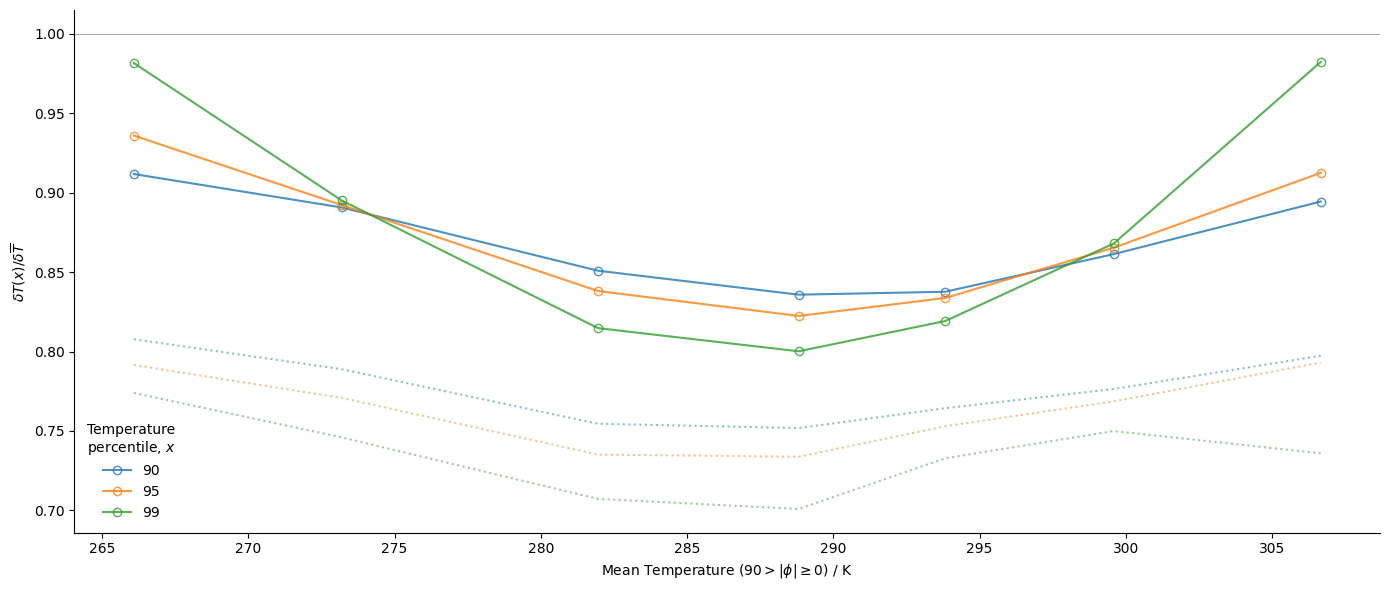

In [59]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_amp_factor_fig=False
fig, ax = plt.subplots(1,1, figsize=(14, 6))
ax.spines[['right', 'top']].set_visible(False)
for j in range(n_quant_plot):
    # for difference between simulations, make x-axis the average between the two mean temperatures
    ax.plot(moving_average(temp_mean_weight, 2),
            np.average(delta_temp_quant[:, :, quant_plot_ind[j]]/delta_temp_median, axis=1, weights=lat_weights),
            color=default_colors[j], alpha=0.8, marker='o', fillstyle='none', label=quant_plot[j])
    ax.plot(moving_average(temp_mean_weight, 2),
            np.average(delta_theory_use[:, :, quant_plot_ind[j]]/delta_theory_use[:, :, median_quant_ind],
                       axis=1, weights=lat_weights), color=default_colors[j], linestyle=':', alpha=0.5)
ax.legend(title='Temperature\npercentile, $x$', frameon=True, framealpha=1, edgecolor="white")
xlim = ax.get_xlim()
ax.hlines(1, xlim[0], xlim[1], color='k', alpha=0.5, linewidth=0.5)
ax.set_xlim(xlim)
if season == 'summer':
    ax.set_xlabel(f'Mean Summer Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
else:
    ax.set_xlabel(f'Mean Temperature (${lat_max}>|\phi| \geq {lat_min}$) / K')
ax.set_ylabel('$\delta T(x)/\delta \overline{T}$')
plt.tight_layout()
if save_fig or save_amp_factor_fig:
    file_name = f'{region.lower()}_amplification_factor_const_rh' if const_rh else f'{region.lower()}_amplification_factor'
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

## Figure 2 of Byrne 2021 - combining $\kappa$
The gradients in the above plot indicate the scaling factors shown in the bottom plot of Byrne 2021 figure 2, but combine all $\kappa$ values indicated by `scaling_factor_kappa_use`. So I plot the gradients versus percentile, $x$, here to replicate the figure.

I include the option for two different quantiles. In Byrne 2021, it is the temperatures averaged over a given percentile - I refer to this as `temp_quant_x`. The other option is using the actual percentile, given here as `temp_quant_p`.

For the mean below, I don't use area weighting, whereas I do above, hence the difference. I don't use it below so that `temp_quant_x` plot always shows a scaling factor of $1$ for $x=0$.

To see if the scaling factor is different for warmer vs colder climates, I compute the gradients using a subset of $\kappa$ values. For colder climates, I use $\kappa=0.2, 0.3, 0.6, 1$ and force the line through $\kappa=1$. For warmer climates, I use $\kappa=1, 1.5, 2, 3.5, 6$ and force the line through $\kappa=1$. The solid line includes all $\kappa$ and is forced through $\kappa = 1$.

In [60]:
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [1, 1, 1]
n_sf = len(sf_tau_use)
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = np.zeros((n_lat, n_quant_all))
scaling_factor_theory_const_rh = np.zeros((n_lat, n_quant_all))

for i in range(n_sf):
    sf_tau_ref_ind = np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0]
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j] = get_gradient(temp_quant_p[sf_tau_use[i], k, j], temp_median[sf_tau_use[i], k], sf_tau_ref_ind)[0]
            if i == 0:
                # Use theory2 version for scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[k, j] = get_gradient(temp_quant_theory2[sf_tau_use[i], k, j],
                                                           temp_quant_theory2[sf_tau_use[i], k, median_quant_ind],
                                                           sf_tau_ref_ind)[0]
                scaling_factor_theory_const_rh[k, j] = get_gradient(temp_quant_theory2_const_rh[sf_tau_use[i], k, j],
                                                                    temp_quant_theory2_const_rh[sf_tau_use[i], k, median_quant_ind],
                                                                    sf_tau_ref_ind)[0]

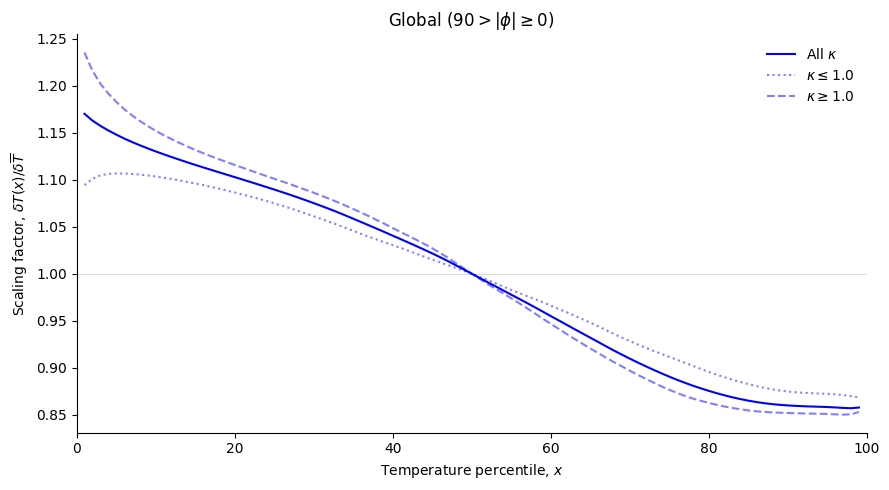

In [65]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='b', label='All $\kappa$')
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='b', linestyle=':', alpha=0.5,
        label=f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$')
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='b', linestyle='--', alpha=0.5,
        label= f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend(frameon=False)
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)

The solid blue line below is the same as that above. The black lines show the theoretical prediction for the blue line, combining all kappa values.

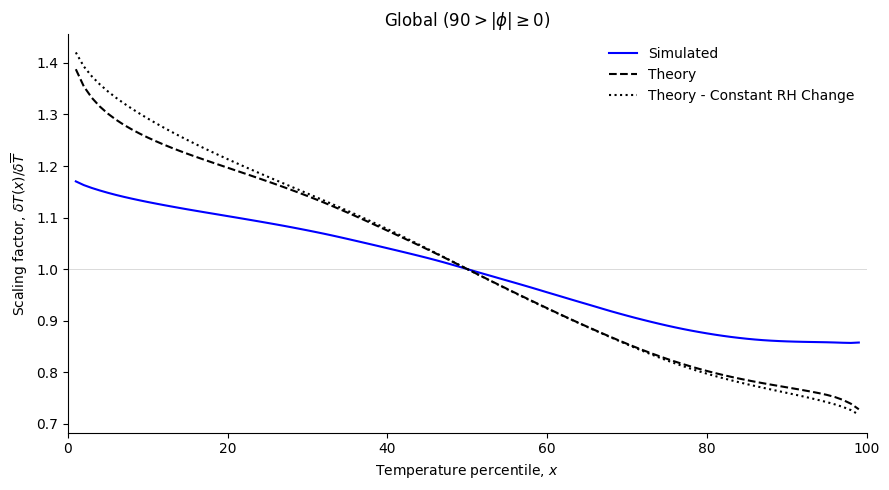

In [62]:
save_sf_theory_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(9, 5))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='b', label='Simulated')
ax.plot(quantiles_all, np.average(scaling_factor_theory, axis=0, weights=lat_weights), color='k', linestyle='--',
        label=f'Theory')
ax.plot(quantiles_all, np.average(scaling_factor_theory_const_rh, axis=0, weights=lat_weights), color='k', linestyle=':',
        label= f'Theory - Constant RH Change')
ax.hlines(1, 0, 100, linewidth=0.5, alpha=0.2, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(2)
# ax.lines.pop(1)
ax.legend(frameon=False)
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
ax.set_title(f'{region.capitalize()} (${lat_max}>|\phi| \geq {lat_min}$)')
plt.tight_layout()
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}",dpi=high_dpi if publish_fig else low_dpi)